In [53]:
from pathlib import Path

import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns

In [54]:
dates_to_visualize = [
                                                                                            "2018-09", "2018-10", "2018-11", "2018-12",
    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12", 
    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12",
    "2023-01", "2023-02",
    # "2024-02",
]

In [55]:
available_data_files = list(Path("../data/httparchive_metrics/nel_config").glob("*.parquet"))

used_data_files = list(filter(lambda file: file.stem.split("_")[-1] in dates_to_visualize, available_data_files))
used_data_files

[WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-07.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/failure_fraction_2019-08.parquet'),
 WindowsPath('../data

### Success fraction configuration over months


In [56]:
# Pick out the Failure Fraction files
ff_files = list(filter(lambda file: file.stem[:file.stem.rfind("_")] == 'include_subdomains', used_data_files))
ff_files

[WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-07.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_config/include_subdomains_2019-08.parquet'),

### Aggregate results to visualize

In [57]:
from results.result_utils import concat_data_from_files, date_to_text_format, MONTHS_MAP

is_data = concat_data_from_files(ff_files)
is_data['nel_include_subdomains'] = is_data['nel_include_subdomains'].astype('category')

is_data['date'] = is_data['date'].map(date_to_text_format)

is_data

,date,nel_include_subdomains,domain_count,domain_percent
0,Sep 2018,false,2,100.000000
0,Oct 2018,true,4,40.000000
1,Oct 2018,false,6,60.000000
0,Nov 2018,true,169,90.374332
1,Nov 2018,false,18,9.625668
...,...,...,...,...
1,Dec 2022,true,13492,0.582863
0,Jan 2023,false,2278733,99.390415
1,Jan 2023,true,13976,0.609585
0,Feb 2023,false,2245332,99.395878


In [58]:
result = is_data[is_data['nel_include_subdomains'] == 'true'].copy()
result['true'] = result['domain_percent']
result[['date', 'true']]

,date,true
0,Oct 2018,40.000000
0,Nov 2018,90.374332
0,Dec 2018,93.351064
0,Feb 2019,95.135135
0,Mar 2019,94.502618
1,Apr 2019,0.534924
1,May 2019,0.608263
1,Jun 2019,0.552933
1,Jul 2019,0.627956
1,Aug 2019,0.613100


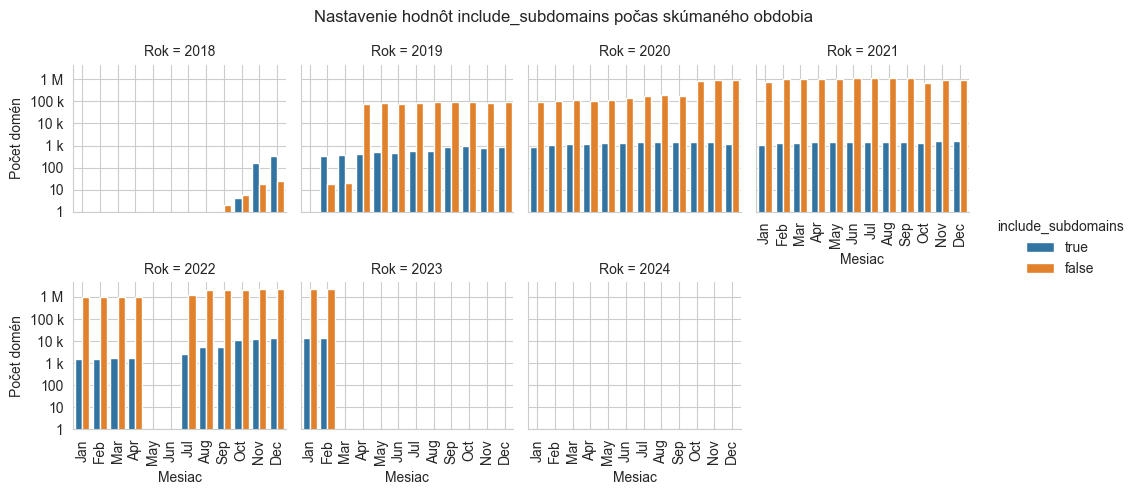

In [165]:
import numpy as np
from results.result_utils import MONTHS_MAP

data = is_data.copy()

data.loc[data['nel_include_subdomains'] == "true", 'include_subdomains'] = "true"
data.loc[data['nel_include_subdomains'] == "false", 'include_subdomains'] = "false"


data['date'] = data['date'].map(pd.to_datetime)

data = data[['date', 'include_subdomains', 'domain_count']]

to_plot = pd.DataFrame(index=pd.date_range('01-01-2018', '31-12-2024', freq='MS'))

include_subdomains = data.groupby(['date'])['include_subdomains'].apply(np.hstack)
to_plot['include_subdomains'] = to_plot.index.map(include_subdomains)

domain_count = data.groupby(['date'])['domain_count'].apply(np.hstack)
to_plot['domain_count'] = to_plot.index.map(domain_count)

to_plot = to_plot.explode(column=['include_subdomains', 'domain_count'])
# to_plot.fillna(0, inplace=True)
to_plot.reset_index(inplace=True)
to_plot.rename(columns={'index': 'date'}, inplace=True)

sns.set_style('whitegrid')

to_plot['Rok'] = to_plot['date'].dt.year
to_plot['Mesiac'] = to_plot['date'].dt.month

g = sns.catplot(to_plot, kind='bar', 
                x='Mesiac', y='domain_count', hue='include_subdomains',
                col='Rok', col_wrap=4,
                height=2.5, aspect=1,
                )


for ax in g.axes:
    ax.xaxis.remove_overlapping_locs = False
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: MONTHS_MAP[str(x + 1).zfill(2)]))
    ax.tick_params(axis='x', which="major", rotation=90)
    
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    ax.set_yscale('log')
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=7))
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    ax.grid(True, which='major', linestyle='-',)

g.set_xlabels("Mesiac")
g.set_ylabels("Počet domén")

g.figure.suptitle("Nastavenie hodnôt include_subdomains počas skúmaného obdobia")
g.tight_layout()

g.savefig("graphs/httparchive_nel_config_is_dist.pdf")